# In the Loop Labeling

In-the-loop AI Assisted Labeling: adds functionality for users to review and correct the initial AI’s labels – the user will review and correct the labels and these corrections will be collected and used as new training data

New training data: used to re-train the initial model (to fine-tune the initial AI model, can be a basic retraining loop or a more complex ML)

Iterative Improvement: for this part, we just repeat the process above of generating the labels, gathering the corrections as new training data, retraining the model on it, etc. and the model should become more accurate each time)

Visualizations: we need to visualize the improvement in accuracy over each iteration, which we can save to a csv file when we collect the new training data – but we also need to tell the user the accuracy each time the model is used so we can generate the accuracy data and print it to user and simultaneously export it to csv file

Export functionality: to allow users to export the newly labeled data back to csv

# Import Statements

In [3]:
# Importing necessary libraries 
import os
import getpass
import pandas as pd
from openai import OpenAI
from IPython.display import display, clear_output

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [5]:
import time

In [6]:
from openai import OpenAI
client = OpenAI()

In [7]:
from ai_assisted_coding_final import assistant

In [6]:
#assistant_manager = assistant.OpenAIAssistantManager(client)

# Create an assistant
#assistant_manager.create_assistant()
#assistant_manager.create_custom_assistant()

asst_oxeOeqbSU6YSmkBdEzHuE1dU


Assistant(id='asst_oxeOeqbSU6YSmkBdEzHuE1dU', created_at=1702250636, description='A custom tool for classifying teacher utterances using gpt-3.5-turbo.', file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n                                            Only answer with the following labels: OTR, PRS, REP, NEU', metadata={}, model='gpt-3.5-turbo', name='Custom Teacher Utterances Classifier', object='assistant', tools=[])

# Instantiating Assistant

In [8]:
assistant_manager = assistant.OpenAIAssistantManager(client)
assistant_manager.create_assistant()

asst_7ULVlRDUjEffFHrn0Gr9CLqB


Assistant(id='asst_7ULVlRDUjEffFHrn0Gr9CLqB', created_at=1702261532, description='A tool for classifying teacher utterances into the categories OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral).', file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: "You n

# Defining Functions

In [9]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df['Text'].tolist()


In [10]:
# def process_lines(lines, assistant_manager):
#     data = []
#     for line in lines:
#         thread, completed_run = assistant_manager.create_thread_and_run(line)
        
#         # Wait for the response and get it
#         response_page = assistant_manager.get_response()

#         # Collect all messages from the response page
#         messages = [msg for msg in response_page]  # Iterating over the response page to collect messages

#         # Extract the user message and the assistant's label
#         if messages:
#             user_message = line
#             # Assuming the last message is from the assistant and contains the label
#             assistant_message = messages[-1].content[0].text.value
#             label = assistant_message.split()[-1]  # Extract label
#             data.append((user_message, label))

#     return data


In [99]:
# def process_lines(lines, assistant_manager, context = ""):
#     data = []
#     assistant_manager.create_thread(context)
#     for line in lines:
#         completed_run = assistant_manager.submit_message(line)
#         response_page = assistant_manager.get_response()
#         messages = [msg for msg in response_page] 
#         assistant_message = messages[-1].content[0].text.value
#         label = assistant_message.split()[-1]

#         data.append((line, label))

#     return data

In [136]:
# This one is WAY FASTER ! 
def process_lines(lines, assistant_manager, context = ""):
    data = []
    additional_context = "Return a list of labels for each utterance separated by \n"
    context += additional_context
    assistant_manager.create_thread(context)

    all_lines = "\n ".join(lines)

    completed_run = assistant_manager.submit_message(all_lines)

    response_page = assistant_manager.get_response()

    messages = [msg for msg in response_page] 

    assistant_message = messages[-1].content[0].text.value

    labels = assistant_message.split("\n")
    # append tupe (line, label) to data using zip
    data = list(zip(lines, labels))
    
    return(data) 


In [137]:
# def process_lines_in_batches(lines, assistant_manager, batch_size=10):
#     batched_data = []
#     for i in range(0, len(lines), batch_size):
#         batch = lines[i:i + batch_size]
#         batched_data.extend(process_lines(batch, assistant_manager))
#     return batched_data

In [138]:
def label_data(unlabeled_text):
    """
    Prompts the user to label the given input.

    Args:
    unlabeled_text (str): The text data that needs labeling.

    Returns:
    str: The label provided by the user.
    """
    #print(f"Label the following line: {unlabeled_text}")
    label = input("Enter the correct label: ")
    while label not in ["NEU", "OTR", "PRS", "REP"]:
        print("Invalid label. Please enter a valid label.")
        label = input("Enter the correct label: ")

    return label

In [16]:
def create_df_from_list(text_list):
    return pd.DataFrame(text_list, columns=["Text"])

In [140]:
def increase_batch_size(batch_size, accuracy):
    if accuracy <= 0.90:
        batch_size = 5
    elif accuracy > 0.90:
        batch_size = 10
    return batch_size

# Testing Functions

In [147]:
# Read data
lines = read_csv('data/231-3.csv')

# Process initial batch for context
initial_data = lines[:5]  # Adjust as needed
unlabeled_data = lines[5:20]
batch_size = 5 

In [148]:
all_labeled_data = []
context = ""
accuracy_scores = []
batch_sizes = []

In [149]:
# Display all lines first
for data in initial_data:
    print(f"Line to label: {data}")


Line to label: Good morning class, today we are going to learn about ancient civilizations.
Line to label: Can anyone tell me what a civilization is?
Line to label: Yes, that's right. A civilization is a complex society with its own government, religion, and economy.
Line to label: Now, let's talk about the first civilization we know of, the Sumerians.
Line to label: They lived in a region called Mesopotamia. Can anyone find Mesopotamia on the map?


In [150]:
#process_lines(initial_data, assistant_manager, context)

In [151]:
# Then collect labels for each line
context = "Here are more examples of how to classify utterances:"
all_labeled_data = []

for data in initial_data:
    label = label_data(data)
    context += f"\nuser: '{data}'\nassistant: '{label}'"
    all_labeled_data.append((data, label))
context += "\nI am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU"

#for i in range(0, len(unlabeled_data), batch_size):
i = 0
while i < len(unlabeled_data):   
    if i >= len(unlabeled_data):
        break
    end_of_batch = min(i + batch_size, len(unlabeled_data))

    batch = unlabeled_data[i:end_of_batch]
    batch_sizes.append(batch_size)
    predictions = process_lines(batch, assistant_manager, context = context)  # Get predictions
    #print(predictions)

    correct_responses = 0
    for text, prediction in predictions:
        print(f"Predicted for '{text}': {prediction}")
        time.sleep(1) 
        user_decision = input(f"Do you agree with this label? (Y/N): ")
        if user_decision.lower() != 'y':
            correct_label = label_data(text) 
        else:
            correct_label = prediction

        if correct_label == prediction:
            correct_responses += 1
        context += f"\nuser: '{text}'\nassistant: '{correct_label}'"
        all_labeled_data.append((text, correct_label))
    
    accuracy = correct_responses / batch_size
    accuracy_scores.append(accuracy)

    # Increase batch size based on accuracy
    batch_size = increase_batch_size(batch_size, accuracy)
    i += batch_size

print(f"Accuracy: {accuracy}")

Predicted for 'Good job, Sarah! Mesopotamia is between the Tigris and Euphrates rivers.': PRS
Predicted for 'The Sumerians invented many things we still use today. Can anyone give me an example?': OTR
Predicted for 'Excellent, they did invent the wheel!': PRS
Predicted for 'They also invented writing. They wrote on clay tablets using a script called cuneiform.': NEU
Predicted for 'Jack, please stop talking while I am teaching.': REP
Predicted for 'The ancient Egyptians also invented paper using a plant called papyrus.': NEU
Predicted for 'Now, let's talk about the ancient Greeks.': NEU
Predicted for 'They are known for their philosophy, art, and mythology. Can anyone name a famous Greek philosopher?': OTR
Predicted for 'Yes, Socrates is a very famous Greek philosopher.': PRS
Predicted for 'The ancient Greeks also invented the Olympics. The first Olympic games were held in 776 BCE.': NEU
Accuracy: 0.5


In [153]:
accuracy_scores

[1.0, 0.5]

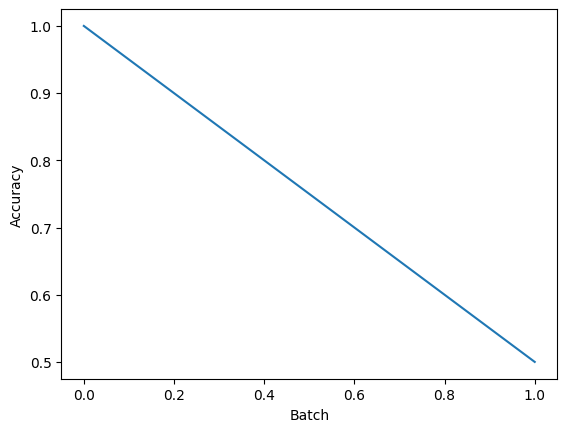

In [152]:
# plot accuracy scores
import matplotlib.pyplot as plt
plt.plot(accuracy_scores)
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.show()

In [ ]:
df_test = pd.read_csv('data/009-1.csv')

In [ ]:
df_test[0:5]

In [ ]:
get_predictions(df_test[0:5], assistant_manager)

# Test Workflow 

In [14]:
# Assuming you have an instance of OpenAIAssistantManager as assistant_manager
lines = read_csv('data/009-1.csv')

In [17]:
assistant_manager.create_thread("")

Thread(id='thread_EP2OnI2OjhOgK0hNkRSzlBmv', created_at=1702257975, metadata={}, object='thread')

In [18]:
assistant_manager.submit_message(lines[0])
response_page = assistant_manager.get_response()
messages = [msg for msg in response_page] 
assistant_message = messages[-1].content[0].text.value
label = assistant_message.split()[-1]

Run(id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', cancelled_at=None, completed_at=1702257978, created_at=1702257977, expires_at=None, failed_at=None, file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: "You need to keep quiet while someone else is 

In [20]:
response_page

SyncCursorPage[ThreadMessage](data=[ThreadMessage(id='msg_UOBcifBcBqUNC09AnRkmZwFX', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=''), type='text')], created_at=1702257975, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'), ThreadMessage(id='msg_juR6FX501z4WJsMpoYKICF6Q', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Good morning class, today we are going to learn about nouns.'), type='text')], created_at=1702257977, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'), ThreadMessage(id='msg_zm20h3opeV17gdNH5RZ79Piv', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', content=[MessageContentText(text=Text(annotations=[], value='NEU'), type='text')], created_at=1702257978, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', thread_

In [22]:
messages 

[ThreadMessage(id='msg_UOBcifBcBqUNC09AnRkmZwFX', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=''), type='text')], created_at=1702257975, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_juR6FX501z4WJsMpoYKICF6Q', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Good morning class, today we are going to learn about nouns.'), type='text')], created_at=1702257977, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_zm20h3opeV17gdNH5RZ79Piv', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', content=[MessageContentText(text=Text(annotations=[], value='NEU'), type='text')], created_at=1702257978, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', thread_id='thread_EP2OnI2OjhOgK0hNkRSzlB

In [23]:
messages[-1].content[0].text.value

'NEU'

In [ ]:
user_message = line
# Assuming the last message is from the assistant and contains the label
assistant_message = messages[-1].content[0].text.value
label = assistant_message.split()[-1]

In [28]:
def process_lines(lines, assistant_manager, context = ""):
    data = []
    assistant_manager.create_thread(context)
    for line in lines:
        completed_run = assistant_manager.submit_message(line)
        
        assistant_manager.submit_message(lines[0])
        response_page = assistant_manager.get_response()
        messages = [msg for msg in response_page] 
        assistant_message = messages[-1].content[0].text.value
        label = assistant_message.split()[-1]

        data.append((line, label))

    return data


In [29]:
process_lines(lines[0:5], assistant_manager)

[('Good morning class, today we are going to learn about nouns.', 'NEU'),
 ('A noun is a word that represents a person, place, thing, or idea.', 'NEU'),
 ('Can anyone give me an example of a noun?', 'NEU'),
 ("That's right, 'dog' is a noun because it is a thing.", 'NEU'),
 ("Let's write down some nouns in our notebooks.", 'NEU')]

In [10]:
# need to make this a group and feed in x number of lines at a time increasing the beatch size along with the accuracy
messages1 = process_lines(lines[0:5], assistant_manager)


In [11]:
messages1

[('Good morning class, today we are going to learn about nouns.', 'NEU'),
 ('A noun is a word that represents a person, place, thing, or idea.', 'NEU'),
 ('Can anyone give me an example of a noun?', 'OTR'),
 ("That's right, 'dog' is a noun because it is a thing.", 'PRS'),
 ("Let's write down some nouns in our notebooks.", 'OTR')]

In [12]:
df1 = pd.DataFrame(messages1, columns=["Text", "Label"])

In [13]:
# need to make this interactive and feed in the label and then make it available for download as a csv
df1

,Text,Label
0,"Good morning class, today we are going to lear...",NEU
1,"A noun is a word that represents a person, pla...",NEU
2,Can anyone give me an example of a noun?,OTR
3,"That's right, 'dog' is a noun because it is a ...",PRS
4,Let's write down some nouns in our notebooks.,OTR


In [14]:
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances::

user: Good morning class, today we are going to learn about nouns.
assistant: NEU
user: A noun is a word that represents a person, place, thing, or idea.
assistant: NEU
user: "Can anyone give me an example of a noun?"
assistant: OTR
user: That's right, 'dog' is a noun because it is a thing.
assistant: PRS

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )


In [15]:
# Wait for the response and get it
response_page_2 = assistant_manager.get_response()

# Collect all messages from the response page
messages2 = [msg for msg in response_page_2]

In [16]:
assistant_message_2 = messages2[-1].content[0].text.value

In [17]:
assistant_message_2

'Understood, go ahead and provide the sentences.'

In [18]:
messages_3 = process_lines(lines[5:10], assistant_manager)

In [19]:
messages_3

[("Now, let's talk about verbs. Does anyone know what a verb is?", 'OTR'),
 ('A verb is a word that describes an action, occurrence, or state of being.',
  'NEU'),
 ('Can someone give me an example of a verb?', 'OTR'),
 ("Great example, 'run' is a verb because it is an action.", 'PRS'),
 ("Now, let's write down some verbs in our notebooks.", 'OTR')]

In [20]:
df3 = pd.DataFrame(messages_3, columns=["Text", "Label"])

In [21]:
df3

,Text,Label
0,"Now, let's talk about verbs. Does anyone know ...",OTR
1,"A verb is a word that describes an action, occ...",NEU
2,Can someone give me an example of a verb?,OTR
3,"Great example, 'run' is a verb because it is a...",PRS
4,"Now, let's write down some verbs in our notebo...",OTR


In [22]:
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances:

user: Can someone give me an example of a pronoun?
assistant: OTR
user: That's right, 'he' is a pronoun because it can take the place of a noun.
assistant: PRS
user: "You need to keep quiet while someone else is reading."
assistant: REP
user: A pronoun is a word that can take the place of a noun.
assistant: NEU
user: I don't appreciate the talking while I am teaching; please show some respect.
assistant: REP
user: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..
assistant: PRS
user: "Before we end, does anyone have any questions?"
assistant: OTR
user: Next class, we will discuss our observations from the experiment.
assistant: NEU

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )

In [23]:
response_page_4 = assistant_manager.get_response()

# Collect all messages from the response page
messages4 = [msg for msg in response_page_4]

In [24]:
messages4

[ThreadMessage(id='msg_jvPaVvNZN4CKkPUgkKbM7sRk', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=' \nGreat. Here are some more examples of how to classify utterances:\n\nuser: Can someone give me an example of a pronoun?\nassistant: OTR\nuser: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\nassistant: PRS\nuser: "You need to keep quiet while someone else is reading."\nassistant: REP\nuser: A pronoun is a word that can take the place of a noun.\nassistant: NEU\nuser: I don\'t appreciate the talking while I am teaching; please show some respect.\nassistant: REP\nuser: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..\nassistant: PRS\nuser: "Before we end, does anyone have any questions?"\nassistant: OTR\nuser: Next class, we will discuss our observations from the experiment.\nassistant: NEU\n\nI am going to provide several more sentences. Only answer with the following thr

In [25]:
messages_5 = process_lines(lines[11:20], assistant_manager)

In [26]:
messages_5

[('An adjective is a word that describes a noun.', 'NEU'),
 ('Can someone give me an example of an adjective?', 'OTR'),
 ("Exactly, 'beautiful' is an adjective because it describes a noun.", 'PRS'),
 ("Let's write down some adjectives in our notebooks.", 'OTR'),
 ('Now we are going to form sentences using nouns, verbs, and adjectives.',
  'OTR'),
 ('A sentence is a group of words that expresses a complete thought.', 'NEU'),
 ("Let's build a sentence together. I'll start with a noun: 'The cat'.",
  'OTR'),
 ('Can someone add a verb to our sentence?', 'OTR'),
 ("Great, now our sentence is: 'The cat runs'.", 'NEU')]

In [27]:
df5 = pd.DataFrame(messages_5, columns=["Text", "Label"])

In [28]:
df5

,Text,Label
0,An adjective is a word that describes a noun.,NEU
1,Can someone give me an example of an adjective?,OTR
2,"Exactly, 'beautiful' is an adjective because i...",PRS
3,Let's write down some adjectives in our notebo...,OTR
4,Now we are going to form sentences using nouns...,OTR
5,A sentence is a group of words that expresses ...,NEU
6,Let's build a sentence together. I'll start wi...,OTR
7,Can someone add a verb to our sentence?,OTR
8,"Great, now our sentence is: 'The cat runs'.",NEU


# Testing Loop 

In [46]:
# Read data
lines = read_csv('data/009-1.csv')

# Process initial batch for context
initial_data = lines[:5]  # Adjust as needed
all_labeled_data = interactive_labeling_loop(initial_data, lines[5:], assistant_manager)

# Display results
print(all_labeled_data[:5])

Sending prompt: 
Good morning class, today we are going to learn about nouns.: Good morning class, today we are going to learn about nouns.
A noun is a word that represents a person, place, thing, or idea.: A noun is a word that represents a person, place, thing, or idea.
Can anyone give me an example of a noun?: Can anyone give me an example of a noun?
That's right, 'dog' is a noun because it is a thing.: That's right, 'dog' is a noun because it is a thing.
Let's write down some nouns in our notebooks.: Let's write down some nouns in our notebooks.

Now, let's talk about verbs. Does anyone know what a verb is?
Received messages: [ThreadMessage(id='msg_roCXG5mvZJ0ieezVnu0MC7Gc', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value="\nGood morning class, today we are going to learn about nouns.: Good morning class, today we are going to learn about nouns.\nA noun is a word that represents a person, place, thing, or idea.: A noun is a word that represents a pers

KeyboardInterrupt: 

In [28]:
lines[11:20]

['An adjective is a word that describes a noun.',
 'Can someone give me an example of an adjective?',
 "Exactly, 'beautiful' is an adjective because it describes a noun.",
 "Let's write down some adjectives in our notebooks.",
 'Now we are going to form sentences using nouns, verbs, and adjectives.',
 'A sentence is a group of words that expresses a complete thought.',
 "Let's build a sentence together. I'll start with a noun: 'The cat'.",
 'Can someone add a verb to our sentence?',
 "Great, now our sentence is: 'The cat runs'."]

In [ ]:
assistant_manager.retrieve_message()

In [21]:
# after labels are fed in send message like this WITH THE new labels 

""" 
Great. Here are some more examples of how to classify utterances::

user: Can someone give me an example of a pronoun?
assistant: OTR
user: That's right, 'he' is a pronoun because it can take the place of a noun.
assistant: PRS
user: "You need to keep quiet while someone else is reading."
assistant: REP
user: A pronoun is a word that can take the place of a noun.
assistant: NEU

I am going to provide several more sentences. Only answer with the following labels: OTR, PRS, REP, NEU
"""

# feed in next batch of labels and iterate 

' \nGreat. Here are some more examples of how to classify utterances::\n\nuser: Can someone give me an example of a pronoun?\nassistant: OTR\nuser: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\nassistant: PRS\nuser: "You need to keep quiet while someone else is reading."\nassistant: REP\nuser: A pronoun is a word that can take the place of a noun.\nassistant: NEU\n\nI am going to provide several more sentences. Only answer with the following labels: OTR, PRS, REP, NEU\n'

In [44]:
# function to process the data in batches
def process_lines_in_batches(lines, assistant_manager, batch_size=10):
    batched_data = []
    for i in range(0, len(lines), batch_size):
        batch = lines[i:i + batch_size]
        batched_data.extend(process_lines(batch, assistant_manager))
    return batched_data

# lines = read_csv('data/009-1.csv')
# batched_messages = process_lines_in_batches(lines, assistant_manager, batch_size=10)
# print(batched_messages[:20])

In [28]:
# file path test file
csv_file_path = 'data/009-1.csv'

# reading in data
lines = read_csv(csv_file_path)

# process data in batches of size 10
batched_messages = process_lines_in_batches(lines, assistant_manager, batch_size=10)

# Display the first few results for testing
print(batched_messages[:5])  # Adjust as needed to check the results

# function to export the data to csv
#def export_to_csv(data, output_file_path):
   # data.to_csv(output_file_path, index=False)


[('Good morning class, today we are going to learn about nouns.', 'nouns.'), ('A noun is a word that represents a person, place, thing, or idea.', 'idea.'), ('Can anyone give me an example of a noun?', 'noun?'), ("That's right, 'dog' is a noun because it is a thing.", 'thing.'), ("Let's write down some nouns in our notebooks.", 'notebooks.')]


In [42]:
def label_data(user_input):
    # This function should take user input and return the labeled data
    # For simplicity, assume the user inputs the correct label directly
    return user_input

def get_predictions_with_context(context, new_data, assistant_manager):
    predictions = []
    for data in new_data:
        prompt = context + f"\n\n{data}"
        print(f"Sending prompt: {prompt}")  # Debugging line
        thread, completed_run = assistant_manager.create_thread_and_run(prompt)
        response_page = assistant_manager.get_response()
        messages = [msg for msg in response_page]
        print(f"Received messages: {messages}")  # Debugging line
        if messages:
            prediction = messages[-1].content[0].text.value.split()[-1]
            predictions.append(prediction)
    return predictions


def interactive_labeling_loop(initial_data, unlabeled_data, assistant_manager):
    context = ""
    batch_size = 5  # Start with 5
    all_labeled_data = []

    # Start with initial data for context
    for data in initial_data:
        label = label_data(data)
        context += f"\n{data}: {label}"
        all_labeled_data.append((data, label))

    # Loop through unlabeled data in batches
    for i in range(0, len(unlabeled_data), batch_size):
        batch = unlabeled_data[i:i + batch_size]
        predictions = get_predictions_with_context(context, batch, assistant_manager)

        # User reviews and corrects predictions
        for data, prediction in zip(batch, predictions):
            print(f"Predicted for '{data}': {prediction}")
            correct_label = label_data(data)
            context += f"\n{data}: {correct_label}"
            all_labeled_data.append((data, correct_label))

        # function to increase batch size based on accuracy or other criteria
        # def increase_batch_size(batch_size, accuracy):
        # if accuracy > 0.9:
        # batch_size += 5
        # if accuracy > 0.95:
        # batch_size += 5
        # return batch_size

        # Increase batch size based on accuracy
        # batch_size = increase_batch_size(batch_size, accuracy)

        # Re-train the model
        # ...

        # Get the accuracy
        # accuracy = get_accuracy()
        # print(f"Accuracy: {accuracy}")

        # Export the labeled data
        # export_to_csv(all_labeled_data, "labeled_data.csv")
        # ...

    return all_labeled_data

# Example usage
# initial_data = [...]  # Your initial 5 sentences
# unlabeled_data = [...]  # The rest of your data
# all_labeled_data = interactive_labeling_loop(initial_data, unlabeled_data, assistant_manager)


In [45]:
# file path test file
csv_file_path = 'data/009-1.csv'

# reading in data
lines = read_csv(csv_file_path)

# process data in batches of size 10
batched_messages = process_lines_in_batches(lines, assistant_manager, batch_size=10)

# Display the first few results for testing
print(batched_messages[:5])  # Adjust as needed to check the results

# function to export the data to csv
#def export_to_csv(data, output_file_path):
# data.to_csv(output_file_path, index=False)


KeyboardInterrupt: 